In [229]:
import numpy as np
from PIL import Image
from bs4 import BeautifulSoup
from scipy.ndimage.filters import correlate, convolve
import matplotlib.pyplot as plt
import time
from skimage import io, transform
from skimage.color import rgb2gray
import json
from bs4 import BeautifulSoup

In [230]:
def crop(png_path, svg_path):
    with open(svg_path) as f:
        soup = BeautifulSoup(f, 'xml')
    image = Image.open(png_path)
    
    svg_tag = soup.find('svg')
    width = float(svg_tag['width'].strip('px'))
    height = float(svg_tag['height'].strip('px'))

    barline = [x for x in soup.find_all('polyline') if x['class'] == 'BarLine'][1]
    right = float(barline['points'].split(',')[0])
    time_sigs = [x for x in soup.find_all('path') if x['class'] == 'TimeSig']
    def get_coords(s):
        # s is a string like M425.006,618.084
        # returns a pair of floats (425.006, 618.084)
        x = s.split()
        x = [y.strip('MCL') for y in x]
        x = np.array(list(map(lambda y: list(map(float, y.split(','))), x)))
        return x

    all_coords = np.concatenate([get_coords(time_sigs[0]['d']), get_coords(time_sigs[1]['d'])], axis=0)
    left = np.max(all_coords[:, 0])
    
    left_frac = left/width
    right_frac = right/width
    
    im_width, im_height = image.size
    image = image.crop((left_frac*im_width, 0, right_frac*im_width, im_height))
    image = image.crop(image.getbbox())
#     image = image.resize((240, 160))
    image_np = np.array(image)[:, :-3, 3]
    image_np = 1-image_np/255
    return(image_np)

In [231]:
def clip_left(x, k):
    return x[:, k:]

def clip_right(x, k):
    return x[:, :x.shape[1]-k]

def extend_left(x, k):
    left_col = x[:, 0].reshape(-1, 1)
    tiled = np.tile(left_col, (1, k))
    return np.concatenate([tiled, x], axis=1)

def extend_right(x, k):
    right_col = x[:, 0].reshape(-1, 1)
    tiled = np.tile(right_col, (1, k))
    return np.concatenate([x, tiled], axis=1)

def extend_up(x, k):
    return np.concatenate([np.ones((k, x.shape[1])), x])

def extend_down(x, k):
    return np.concatenate([x, np.ones((k, x.shape[1]))])

def horizontal_jiggle(x, N, p):
    jiggle_direction = np.random.choice([1, -1])
    y = np.random.uniform(size=(N, x.shape[0]))
    for i in range(N):
        mask = y[i] < p
        if jiggle_direction == 1:
            x[mask, 1:] = x[mask, :-1]
        else:
            x[mask, :-1] = x[mask, 1:]
    return x

def vertical_jiggle(x, N, p):
    jiggle_direction = np.random.choice([1, -1])
    y = np.random.uniform(size=(N, x.shape[1]))
    for i in range(N):
        mask = y[i] < p
        if jiggle_direction == 1:
            x[1:, mask] = x[:-1, mask]
        else:
            x[:-1, mask] = x[1:, mask]
    return x

def add_noise(x, p, color='black'):
    if color == 'black':
        noise = np.random.choice([0, 1], size=x.shape, p=[p, 1-p])
        return np.minimum(x, noise)
    else:
        noise = np.random.choice([0, 1], size=x.shape, p=[1-p, p])
        return np.maximum(x, noise)

def make_bw(x):
    return np.around(x)

def convert_to_1(x):
    image = Image.fromarray(x*255)
    image = image.convert('1')
    x = np.array(image)/255
    return x

def thicken(x, dims):
    x = 1-x
    k = np.ones(dims)
    x = np.minimum(correlate(x, k), 1)
    return 1-x

def add_splotch(x, N, r):
    a = np.random.randint(x.shape[0])
    b = np.random.randint(x.shape[1])
    splotch_points = np.around(np.array([a, b]) + np.random.randn(N, 2)*r)
    splotch_points = splotch_points.astype(int)
    for point in splotch_points:
        if 0 <= point[0] < x.shape[0] and 0 <= point[1] < x.shape[1]:
            x[point[0], point[1]] = np.minimum(x[point[0], point[1]], 0)
    return x
            
def shrink_whitespace(x, p):
    white_rows = np.nonzero(x.mean(axis=1) == 1)[0]
    white_rows = white_rows[(white_rows >= int(x.shape[0]*3/8)) & (white_rows < int(x.shape[0]*5/8))]
    excluded_rows = np.random.choice(white_rows, size=int(p*len(white_rows)), replace=False)
    mask = np.ones(x.shape[0])
    mask[excluded_rows] -= 1
    included_rows = np.nonzero(mask)[0]
    return x[included_rows]

def shrink_note_spacing(x, p):
    empty_columns = np.nonzero((1-x).sum(axis=0) <= 12)[0]
    excluded_columns = np.random.choice(empty_columns, size=int(p*len(empty_columns)), replace=False)
    mask = np.ones(x.shape[1])
    mask[excluded_columns] -= 1
    included_columns = np.nonzero(mask)[0]
    return x[:, included_columns]

In [232]:
def random_shrink_whitespace(x):
    p = np.random.rand()
    x = shrink_whitespace(x, p)
    return x
    
def random_shrink_note_spacing(x):
    p = np.minimum(np.abs(np.random.randn()*0.3), 1)
    x = shrink_note_spacing(x, p)
    return x
    
def random_resize(x):
    left = int(np.maximum(-1, x.shape[1]*np.random.randn()*0.1))
    right = int(np.maximum(-10, x.shape[1]*np.random.randn()*0.1))
    top = int(np.abs(x.shape[0]*np.random.randn()*0.15))
    bottom = int(np.abs(x.shape[0]*np.random.randn()*0.15))
    if left > 0:
        x = extend_left(x, left)
    else:
        x = clip_left(x, np.abs(left))
    if right > 0:
        x = extend_right(x, right)
    else:
        x = clip_right(x, np.abs(right))
    x = extend_up(x, top)
    x = extend_down(x, bottom)
    return x

def random_splotches(x):
    n = np.random.randint(5)
    for _ in range(n):
        N = np.random.randint(200, 300)
        r = np.random.uniform(0.5, 1)
        x = add_splotch(x, N, r)
    return x

def random_noise(x):
    color = np.random.choice(['black', 'white'])
    if color == 'black':
        p = np.abs(np.random.randn()*0.01)
#         p = np.random.uniform(0, 0.01)
    else:
        p = np.random.uniform(0, 0.05)
    x = add_noise(x, p, color)
    return x

def random_jiggle(x):
    N = np.random.randint(0, 2)
    p = np.random.randn()*0.05
    x = vertical_jiggle(x, N, p)
    N = np.random.randint(0, 2)
    p = np.abs(np.random.randn()*0.2)
    x = horizontal_jiggle(x, N, p)
    return x

def random_thicken(x):
    dim_choices = [(2, 1), (1, 2), (2, 2), (3, 3), (3, 4), (4, 3), (4, 4)]
    dims = dim_choices[np.random.randint(len(dim_choices))]
    x = thicken(x, dims)
    return x

In [233]:
def rgb_to_grayscale(x):
    # x is an numpy array with shape (a, b, 3)
    a, b, _ = x.shape
    weights = np.array([[0.2125, 0.7154, 0.0721]]).T
    return (x @ weights).reshape(a, b)

In [266]:
def random_pre_augmentation(x):
    if np.random.rand() < 0.8:
        x = random_shrink_whitespace(x)
    if np.random.rand() < 0.8:
        x = random_shrink_note_spacing(x)
    if np.random.rand() < 0.8:
        x = random_resize(x)
    if np.random.rand() < 0.5:
        x = random_thicken(x)
    if np.random.rand() < 0.3:
        x = random_splotches(x)
    if np.random.rand() < 0.6:
        x = random_noise(x)
    if np.random.rand() < 0.3:
        x = random_jiggle(x)
    if np.random.rand() < 0.3:
        x = transform.rotate(x, np.random.randn()*0.6, cval=1)
    return x

def rescale(x):
    x = transform.resize(x, (200, 200))
    return x

def random_post_augmentation(x):
    if np.random.rand() < 0.5:
        x = random_noise(x)
    if np.random.rand() < 0.5:
        x = random_jiggle(x)
    if np.random.rand() < 0.3:
        x = random_splotches(x)
    return x

def process(png_path, svg_path):
    image = crop(png_path, svg_path)
    image = random_pre_augmentation(image)
    image = rescale(image)
    image = random_post_augmentation(image)
    return image

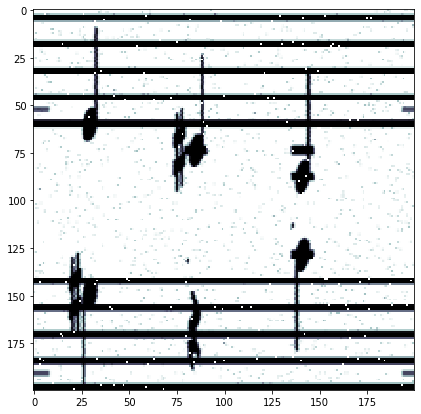

In [301]:
n = np.random.randint(10000)
image = process(f'data2/{n}-1.png', f'data2/{n}-1.svg')
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image, cmap='bone')